In [1]:
from integsol.mesh.mesh import Mesh
from integsol.structures.vectors import VectorField
from integsol.structures.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.structures.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/scicodes/integsol/test_inputs/mesh_75nm.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.53%

Calculate measures for tri type of elements
Progress: 99.83%

Calculate measures for tet type of elements
Progress: 99.97%

Calculation of measures of all elements finished in 48.865864515304565 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T
elements = mesh.elements_coordinates
len(centers.T)

3201

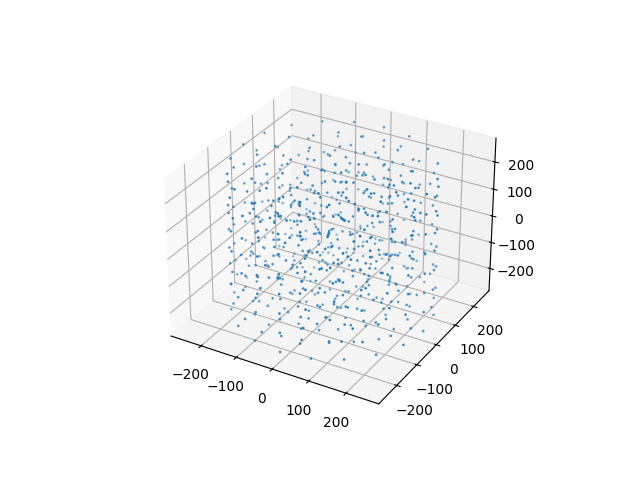

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [176]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [6]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/scicodes/integsol/test_inputs/magnetization_75nm.txt",
    mesh=mesh,
    dim=3)

In [7]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_
del M0

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 3.8170127868652344 seconds.


In [8]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 1563.9314405918121 seconds.


In [9]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/scicodes/integsol/test_inputs/H_eff_75nm.txt",
    mesh=mesh,
    dim=3)

"""_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T"""

'_H_eff = H_eff.vectorize()\nvals_H_eff = H_eff.values.T'

In [10]:
H_0 = VectorField(
    mesh=mesh,
    coordinates=centers.T,
    values= 5e6 * np.array([[0,0,1] for _ in centers.T])
)
H_0_coordinates = H_0.coorrdinates.T
H_0_values = H_0.values.T

In [ ]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    H_0_coordinates[0],
    H_0_coordinates[1],
    H_0_coordinates[2],
    H_0_values[0],
    H_0_values[1],
    H_0_values[2],
    length=1e-5,
)

plt.show()

In [11]:
H_0_cpo = CPO(
    mesh=mesh,
    left_vector=H_0
)
H_0_times_ = H_0_cpo.to_mesh_matrix()

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 2.208679676055908 seconds.


In [12]:
H_eff_cpo = CPO(
    mesh=mesh,
    left_vector=H_eff
)
H_eff_times_ = H_eff_cpo.to_mesh_matrix()
del H_eff

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 2.3643417358398438 seconds.


In [13]:
IntConvOp = matmul(M0_times_,int_G_)

In [14]:
LLG_operator = gamms * (H_0_times_ + H_eff_times_  - M_s * IntConvOp)

del IntConvOp
LLG_operator

tensor([[ 1.0063e+08, -1.1141e+11,  8.7187e+08,  ..., -1.0786e+05,
          1.0730e+05, -1.2328e+05],
        [ 1.1078e+11, -1.0064e+08, -8.5188e+08,  ...,  2.4188e+04,
          1.0787e+05,  2.1982e+05],
        [-7.3462e+08,  7.1867e+08,  7.3875e+03,  ..., -3.4283e+00,
         -4.8694e-01, -9.5947e+00],
        ...,
        [-1.2042e+05,  1.2163e+05, -1.3870e+05,  ...,  3.3230e+07,
         -1.1124e+11,  7.7309e+08],
        [ 2.5987e+04,  1.2042e+05,  2.4664e+05,  ...,  1.1105e+11,
         -3.3236e+07, -1.3422e+09],
        [-5.4133e-01, -1.4984e+00, -3.6454e+00,  ..., -5.7871e+08,
          9.3722e+08,  5.9363e+03]])

In [15]:
#omega_char = gamms * h_mx
#null_LLG = LLG_operator + 1j * omega_char * np.identity(n=len(LLG_operator))
#null_LLG#
#
#U, S, Vh = np.linalg.svd(null_LLG)

#null_space = np.compress(S <= 5.2e13, Vh, axis=0)
#null_space.T

dm_0 = VectorField(mesh=mesh, coordinates=centers.T, values=0.1 * np.array([[1 / np.sqrt(2), 1 / np.sqrt(2), 0] for _ in centers.T]))

dm_0_coordinates = dm_0.coorrdinates.T
dm_0_values = dm_0.values.T
_dm_0 = dm_0.vectorize()

In [ ]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    dm_0_coordinates[0],
    dm_0_coordinates[1],
    dm_0_coordinates[2],
    dm_0_values[0],
    dm_0_values[1],
    dm_0_values[2],
    length=300,
)

plt.show()

In [16]:
from scipy.sparse.linalg import eigs as speigs

eigs = speigs(np.array(LLG_operator), k=10, tol=1e-15)

/tmp/ipykernel_1271/736403224.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  eigs = speigs(np.array(LLG_operator), k=10, tol=1e-15)


In [17]:
eigs

(array([ -133642.38716888+1.15941740e+11j,
         -133642.38716888-1.15941740e+11j,
          422488.99057007+1.15917129e+11j,
          422488.99057007-1.15917129e+11j,
          -97057.02217484+1.15348247e+11j,
          -97057.02217484-1.15348247e+11j,
           84952.92734528+1.15331304e+11j,
           84952.92734528-1.15331304e+11j,
        15682211.74669278+1.14974641e+11j,
        15682211.74669278-1.14974641e+11j]),
 array([[ 7.97585849e-04+8.18148714e-04j,  7.97585849e-04-8.18148714e-04j,
          2.08928190e-03+2.19361380e-03j, ...,
          5.53657759e-03-5.78859128e-03j, -3.12399358e-03-9.28402426e-05j,
         -3.12399358e-03+9.28402426e-05j],
        [ 8.30392566e-04-8.69596585e-04j,  8.30392566e-04+8.69596585e-04j,
          2.21333359e-03-2.16441683e-03j, ...,
          5.83248630e-03+5.69098749e-03j, -5.46324915e-05+3.19248022e-03j,
         -5.46324915e-05-3.19248022e-03j],
        [-1.05764921e-05-8.99189108e-08j, -1.05764921e-05+8.99189108e-08j,
         -2.7

In [18]:
eigenvalues = eigs[0]#.eigenvalues
eigenvectors = eigs[1].T#.eigenvectors.T
eigenvalues = (1j * np.array(eigenvalues))
#eigenvalues_idx = np.where(abs(eigenvalues.imag) < 10000000)[0]
#eigenvalues = eigenvalues[eigenvalues_idx].real
#eigenvalues_idx = np.where(abs(eigenvalues) > 1e9)[0]
#eigenvalues = eigenvalues[eigenvalues_idx]
#eigenvalues, eigenvalues_idx

In [19]:
eigenvalues[0]

np.complex128(-115941740060.15253-133642.38716888428j)

In [26]:
dm = VectorField(
    mesh=mesh,
    coordinates=mesh.elements_centers['tet'],
)
n = 3
_dm = eigenvectors[3] #+ eigenvectors[1] + eigenvectors[4] + eigenvectors[5] + eigenvectors[8] + eigenvectors[9]
dm.devectorize(np.array(_dm).real)

dm_values = dm.values.T
dm_coordinates = dm.coorrdinates.T
dm_values

array([[ 2.08928190e-03,  1.70238667e-03,  2.55838127e-03, ...,
        -1.49120762e-03, -1.18735844e-03, -2.11136728e-04],
       [ 2.21333359e-03,  1.77751985e-03,  2.65758891e-03, ...,
        -1.52231734e-03, -1.22764725e-03, -2.11526651e-04],
       [-2.73241985e-05, -1.87017544e-05, -2.70210060e-05, ...,
         2.09652153e-05,  1.87425758e-05,  3.40236116e-06]])

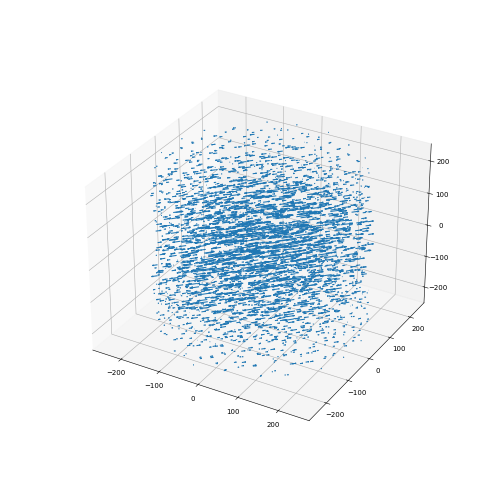

In [27]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10), dpi=50)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    dm_coordinates[0],
    dm_coordinates[1],
    dm_coordinates[2],
    dm_values[0],
    dm_values[1],
    dm_values[2],
    length=1000,
    
)

plt.show()

In [ ]:
eigenvalues[0]

In [ ]:
5e5 * gamms